In [1]:
# Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import topology
import electrostatic
import tunneling
import model

Init disordered Network Topology and Electrostatic Properties:
- Number of nanopartciles $N_{NP}$ and number of junctions per $N_{J}$
- Electrode Positions as list of cartesian coordinates `[[x_1, y_1], [x_2, y_2], [x_3, y_3], ...]` \
Network is placed inside box of size 1 with electrodes attached to closest nanoparticle

In [2]:
# Network Parameter
N_particles     = 50
N_junctions     = 4
electrode_pos   = [[-1,-1],[1,1]]
N_electrodes    = len(electrode_pos)

radius, radius_std  = 10.0, 0.0
eps_r, eps_s        = 2.6, 3.9
np_distance         = 1

# Topology Class
random_topology = topology.topology_class()
random_topology.random_network(N_particles, N_junctions)
random_topology.add_electrodes_to_random_net(electrode_pos)
random_topology.graph_to_net_topology()

# Return Graph Object and Connection Array
G_random    = random_topology.return_graph_object()
random_net  = random_topology.return_net_topology()

# Electrostatic
random_electrostatic = electrostatic.electrostatic_class(net_topology=random_net)
random_electrostatic.init_nanoparticle_radius(radius, radius_std)
random_electrostatic.calc_capacitance_matrix(eps_r, eps_s, np_distance)

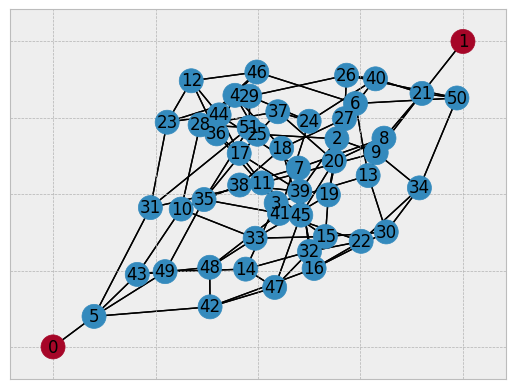

In [3]:
# Node Positions
fixed_pos               = {i : val for i, val in enumerate(electrode_pos)}
pos                     = nx.spring_layout(G=G_random, pos=fixed_pos, fixed=[i for i in range(N_electrodes)])
pos_vals                = np.array(list(dict(sorted(pos.items())).values()))
pos_vals_e              = pos_vals[N_electrodes:]
pos_vals_e              = 1.6*(pos_vals_e - np.min(pos_vals_e,axis=0))/(np.max(pos_vals_e,axis=0) - np.min(pos_vals_e,axis=0)) - 0.8
pos_vals[N_electrodes:] = pos_vals_e

for i in range(N_particles):
    pos[i] = pos_vals[i,:]

# Node Colors
colors                  = np.repeat('#348ABD', N_particles+N_electrodes)
colors[-N_electrodes:]  = '#A60628'

with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=G_random, pos=pos, ax=ax, node_color=colors, arrows=False)
    plt.show()

Input Voltages

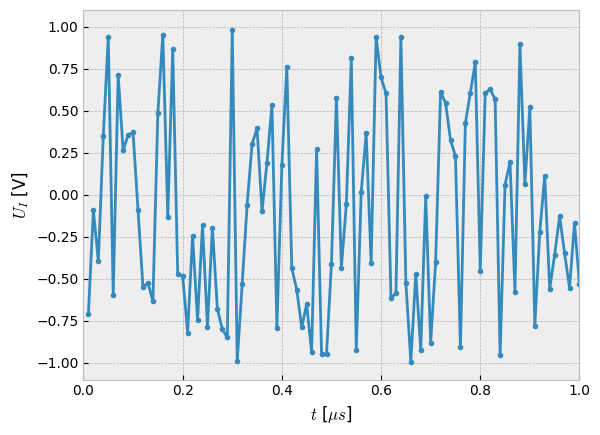

In [4]:
N_voltages  = 10000
voltages    = np.zeros((N_voltages, N_electrodes+1))
step_size   = 1e-8
time_steps  = np.cumsum(np.repeat(step_size, N_voltages))

input_volt      = np.random.uniform(-1,1,N_voltages)
voltages[:,0]   = input_volt 
with plt.style.context("bmh"):
    
    plt.plot(time_steps*10**6, input_volt, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [V]")
    plt.xlim(0,1)
    plt.show()

In [5]:
# First Charge Vector:
random_electrostatic.init_charge_vector(voltages[0])
inv_capacitance_matrix  = random_electrostatic.return_inv_capacitance_matrix()
charge_vector           = random_electrostatic.return_charge_vector()

In [ ]:
def run_simulation(voltages, electrostatic_class, target_electrode=-1, T_val=0.0):
    
    # First time step
    electrostatic_class.init_charge_vector(voltage_values=voltages[0])
    net_topology            = electrostatic_class.return_net_topology()
    inv_capacitance_matrix  = electrostatic_class.return_inv_capacitance_matrix()
    charge_vector           = electrostatic_class.return_charge_vector()

    # Model
    net_model = tunneling.tunnel_class(net_topology=net_topology, inv_capacitance_matrix=inv_capacitance_matrix)
    net_model.init_potential_vector(voltage_values=voltages[0])
    net_model.init_const_capacitance_values()

    # Return Model Arguments
    potential_vector                                                                        = net_model.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = net_model.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = net_model.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = net_model.return_advanced_indices()
    temperatures, temperatures_co                                                           = net_model.return_const_temperatures(T=T_val)
    resistances, resistances_co1, resistances_co2                                           = net_model.return_random_resistances()

    # Simulation Class
    simulation = model.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                                    temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                                    co_adv_index3, N_electrodes, N_particles)
    
    # simulation.reach_equilibrium()

    simulation.time                     = 0.0
    simulation.counter_output_jumps_neg = 0
    simulation.counter_output_jumps_pos = 0

    offset                      = electrostatic_class.get_charge_vector_offset(voltage_values=voltages[0])
    simulation.charge_vector    =- offset
    
    j = 0

    for i, voltage_values in enumerate(voltages[:-1]):

        offset                      = electrostatic_class.get_charge_vector_offset(voltage_values=voltage_values)
        simulation.charge_vector    += offset
        
        simulation.time = time_steps[i]
        time_target     = time_steps[i+1]

        # Update Electrode Potentials
        simulation.potential_vector[:(len(voltage_values)-1)]  = voltage_values[:(len(voltage_values)-1)]
        simulation.kmc_time_simulation(target_electrode, time_target)
        jump_diff_mean, jump_diff_std, mean_state, executed_jumps, executed_cojumps, total_jumps = simulation.return_target_values()
        
        # self.output_values.append(np.array([-1, total_jumps, jump_diff_mean, jump_diff_std]))
        # self.microstates.append(mean_state)
        # self.average_jumps.append(executed_jumps)
        # self.average_cojumps.append(executed_cojumps)

        # if ((i+1) % save_th == 0):
            
        #     save_target_currents(np.array(self.output_values), self.voltages[j:(i+1),:], self.path1)
        #     save_mean_microstate(self.microstates, self.path2)
        #     save_jump_storage(self.average_jumps, adv_index_rows, adv_index_cols, self.path3)
        #     self.output_values      = []
        #     self.microstates        = []
        #     self.average_jumps      = []
        #     self.average_cojumps    = []
        #     j                       = i+1
        
        offset                      = electrostatic_class.get_charge_vector_offset(voltage_values=voltage_values)
        simulation.charge_vector    =- offset